In [1]:
import sys
import os
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath(os.path.join(os.path.abspath('..'),os.pardir))
numericalExperimentsPath = os.path.abspath('..')

sys.path.append(PROJECT_ROOT)

from electronTransportCode.MCEstimator import DoseEstimator
from electronTransportCode.ParticleModel import SimplifiedEGSnrcElectron
from electronTransportCode.MCParticleTracer import KDMC, AnalogParticleTracer
from lungSetup import LungInitialConditions, LungSimulationDomain, I_BONE
from electronTransportCode.ProjectUtils import E_THRESHOLD, ERE

%matplotlib widget

In [2]:

# Load particle tracers
analogTracer3d: AnalogParticleTracer = pickle.load(open('data/analogTracer3d.pkl', 'rb'))
doseEstimatorK3d: DoseEstimator = pickle.load(open('data/doseEstimatorK3d.pkl', 'rb'))[0]
analogTracer2d = pickle.load(open('data/analogTracer2d.pkl', 'rb'))
doseEstimatorK2d = pickle.load(open('data/doseEstimatorK2d.pkl', 'rb'))[0]
simDomain: LungSimulationDomain = analogTracer3d.simDomain
simOptions: LungInitialConditions = analogTracer3d.simOptions
bins = simDomain.xbins
width = simDomain.width

In [3]:
print(analogTracer2d.averageNbCollisions)
print(analogTracer3d.averageNbCollisions)

80545.63631999982
79556.45983999985


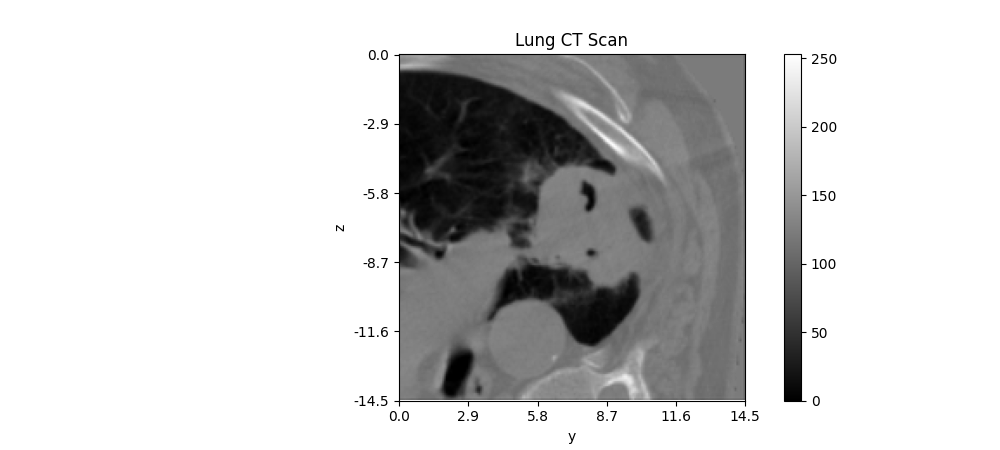

In [4]:
fig, ax1 = plt.subplots(figsize=(10, 4.5))
pos = ax1.imshow(Image.fromarray(simDomain.grayScaleImage), cmap='gray')  # type: ignore
ax1.set_title('Lung CT Scan')
ax1.set_xlabel('y')
ax1.set_ylabel('z')
nticks = 6
ax1.set_xticks(np.linspace(0, bins, nticks))
ax1.set_xticklabels(np.linspace(0, width, nticks))
ax1.set_yticks(np.linspace(0, bins, nticks))
ax1.set_yticklabels(np.linspace(0, -width, nticks))
fig.colorbar(pos, ax=ax1)


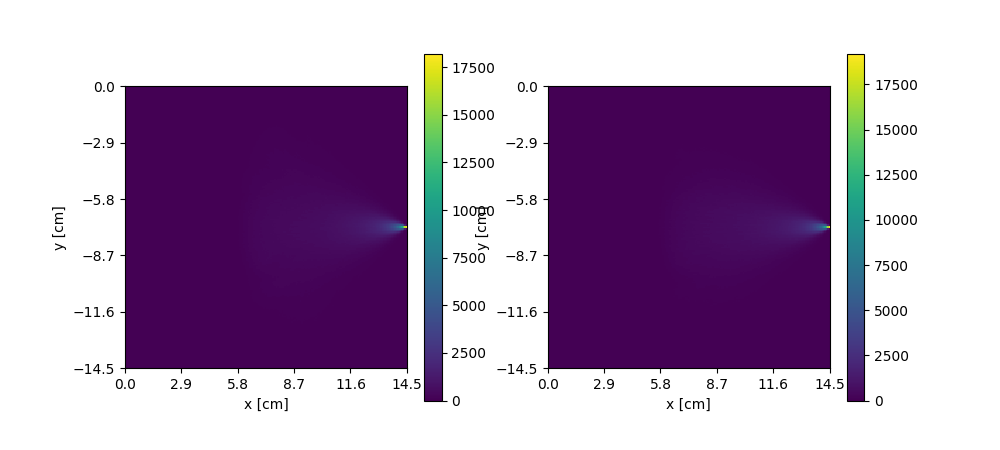

In [5]:
# Plot energy deposition in a subdomain
xBins = np.linspace(0, width, bins+1)
yBins = np.linspace(-width, 0, bins+1)

energyDepositionK3d_ERE = np.flipud(np.reshape(doseEstimatorK3d.scoreMatrix, (bins, bins)))
energyDepositionK2d_ERE = np.flipud(np.reshape(doseEstimatorK2d.scoreMatrix, (bins, bins)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))

pox1 = ax1.matshow(energyDepositionK3d_ERE, extent=[xBins.min(), xBins.max(), yBins.min(), yBins.max()])
ax1.set_xticks(np.linspace(xBins.min(), xBins.max(), nticks))
ax1.set_yticks(np.linspace(yBins.max(), yBins.min(), nticks))
ax1.xaxis.tick_bottom()
ax1.set_xlabel('x [cm]')
ax1.set_ylabel('y [cm]')
fig.colorbar(pox1, ax=ax1)

pox2 = ax2.matshow(energyDepositionK2d_ERE, extent=[xBins.min(), xBins.max(), yBins.min(), yBins.max()])
ax2.set_xticks(np.linspace(xBins.min(), xBins.max(), nticks))
ax2.set_yticks(np.linspace(yBins.max(), yBins.min(), nticks))
ax2.xaxis.tick_bottom()
ax2.set_xlabel('x [cm]')
ax2.set_ylabel('y [cm]')
fig.colorbar(pox2, ax=ax2)


/tmp/ipykernel_7912/3106981375.py:9: RuntimeWarning: divide by zero encountered in log
  ax1.contourf(X, Y, np.log(energyDepositionK3d_ERE), alpha=0.5, extent=extent, cmap='plasma', levels=levels)
/tmp/ipykernel_7912/3106981375.py:13: RuntimeWarning: divide by zero encountered in log
  ax2.contourf(X, Y, np.log(energyDepositionK2d_ERE), alpha=0.5, extent=extent, levels=levels)


Text(0.5, 1.0, '2d simulation')

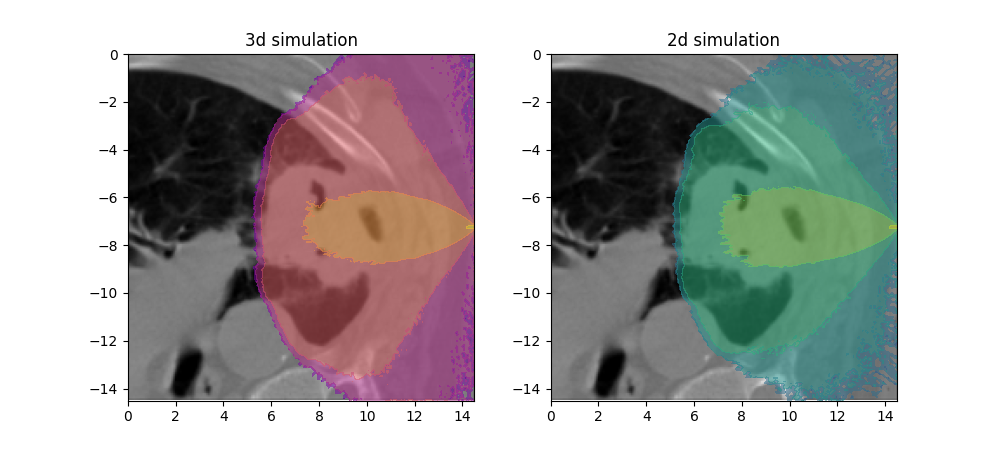

In [9]:
extent = [xBins.min(), xBins.max(), yBins.min(), yBins.max()]
xBins1 = np.linspace(0, width, bins)
yBins1 = np.linspace(-width, 0, bins)
X, Y = np.meshgrid(xBins1, yBins1)
levels = 5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))

ax1.imshow(Image.fromarray(simDomain.grayScaleImage), cmap='gray', extent=extent)  # type: ignore
ax1.contourf(X, Y, np.log(energyDepositionK3d_ERE), alpha=0.5, extent=extent, cmap='plasma', levels=levels)
ax1.set_title('3d simulation')

ax2.imshow(Image.fromarray(simDomain.grayScaleImage), cmap='gray', extent=extent)  # type: ignore
ax2.contourf(X, Y, np.log(energyDepositionK2d_ERE), alpha=0.5, extent=extent, levels=levels)
ax2.set_title('2d simulation')


### Initial direction

In [7]:
testInit = LungInitialConditions()
N = 1000

# Sample a lot of initial vectors
vecs = np.empty((N, 3), dtype=float)
for i in range(N):
    vecs[i, :] = testInit.initialDirection()


(-1.0, 1.0)

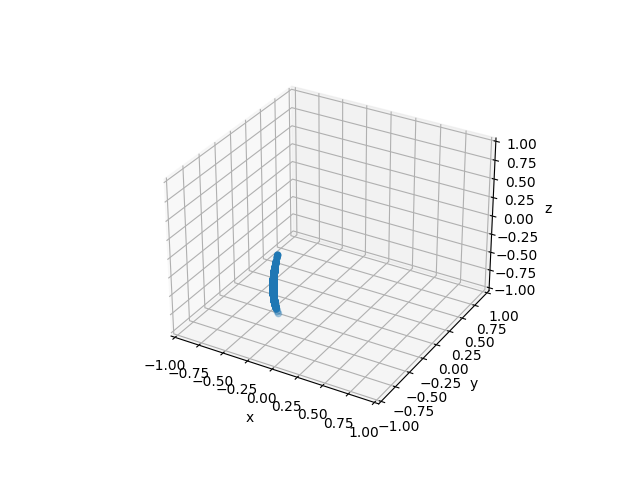

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(vecs[0:1000, 0], vecs[0:1000, 1], vecs[0:1000, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])